# Visual Odometry pipeline
A naive visual odometry implementation with OpenCV & Python

In [14]:
# Fetch data
!bash ./fetch_data.sh

In [15]:
import io
import cv2
import time
import numpy as np
import PIL.Image
from matplotlib import pyplot as plt
from IPython import display
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
from os import listdir
from os.path import isfile, join

seq = None
mono_folder = None
data_folder = None
train_image_names = None
train_labels = None

KITTI = True
input = './videos/test_countryroad.mp4'
# input = 0

if KITTI == True:
    seq = '00'
    mono_folder = 'image_2'
    data_root = '/Users/haydenpennington/dev/data/kitti/'
    data_folder = data_root + 'sequences/' + seq + '/' + mono_folder + '/'
    train_image_names = sorted([f for f in listdir(data_folder) if isfile(join(data_folder, f))])
    
    with open(data_root + 'poses/' + seq + '.txt', 'r') as f:
        train_labels = [x.split() for x in f.readlines()]
        train_labels = np.array([[float(x) for x in y] for y in train_labels])
        train_labels = train_labels.reshape(-1, 3, 4)
        

# print(train_image_names)

## Create the ORB feature detector
orb = cv2.ORB_create()


In [16]:
def normalize(Kinv, pts):
    pts = np.concatenate([pts, np.array([1.0])])
    return np.dot(Kinv, pts).T[:2]

In [17]:
def match_frames(frame1, frame2, corners1, corners2, kps1, kps2, descriptors1, descriptors2):
    bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)
    matches = np.asarray(matches)
    
    pairs = []
    norm_pairs = []

    # W,H = 1920, 1080
    # W, H = 1280, 720
    H, W = frame1.shape
    # W,H = 1920 // 4, 1080 // 4
    F = W // 2
    K = np.array([[F,0,W//2],[0,F,H//2],[0,0,1]])
    Kinv = np.linalg.inv(K)

    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            pt1 = np.asarray(kps1[m.queryIdx].pt)
            pt2 = np.asarray(kps2[m.trainIdx].pt)
            pairs.append((pt1, pt2))
            pt1 = normalize(Kinv, pt1)
            pt2 = normalize(Kinv, pt2)
            norm_pairs.append((pt1, pt2))

    pairs = np.asarray(pairs)
    norm_pairs = np.asarray(norm_pairs)

    if pairs[:, 0].shape[0] >= 16 and pairs[:, 1].shape[0] >= 16:

        try:
            model, inliers = ransac(
                (norm_pairs[:, 0], norm_pairs[:, 1]),
                FundamentalMatrixTransform,
                min_samples=16,
                residual_threshold=0.02,
                max_trials=200
            )

            # return norm_pairs[inliers], pairs[inliers], model.params
            return norm_pairs[inliers], pairs[inliers], model.params
        except ValueError as error:
            print(error)
            return None
        
    else:
        return None


In [18]:
def display_mat(M, fmt='jpeg'):
    f = io.BytesIO()
    PIL.Image.fromarray(M).save(f, fmt)
    display.display(display.Image(data=f.getvalue()))

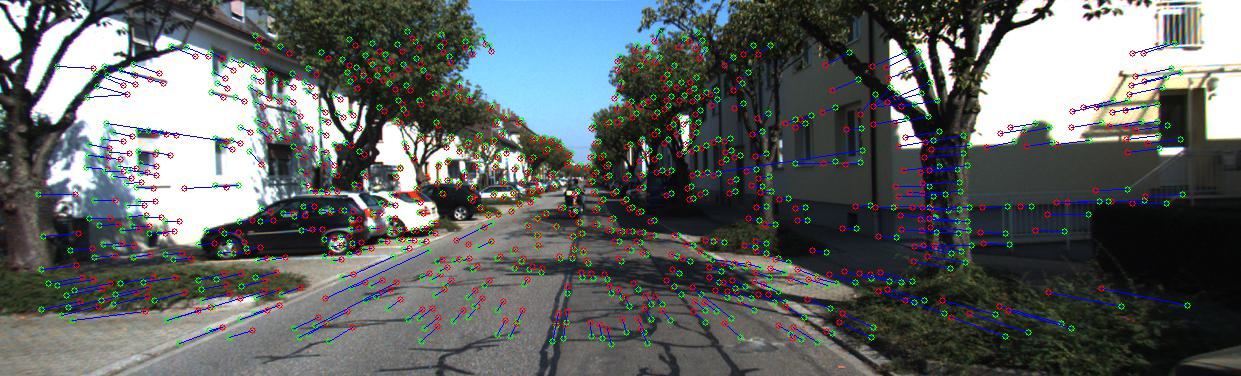

In [19]:
cap = None
if KITTI == False:
    cap = cv2.VideoCapture(input)
    # cap = cv2.VideoCapture(0)

last = None
last_corners = None
# last_keypoints = None
last_kps = None
last_descriptors = None

R_abs = np.eye(3)
t_abs = np.zeros(3)
last_R = np.eye(3)
last_t = np.zeros(3)
t_abs_all = []
t_abs_gt = []

i = 0
%matplotlib widget
while (KITTI == True and i < len(train_image_names)) or (cap is not None and cap.isOpened()):
    t0 = time.time()
    ret, im_original, label = None, None, None
    if KITTI == True:
        ret, im_original, label = True, cv2.imread(data_folder + train_image_names[i]), train_labels[i]
    else:
        ret, im_original = cap.read()
    

    if ret:
        im = im_original
        # im = cv2.resize(im_original, (640, 480))
        multiplier_x = im_original.shape[1] / im.shape[1]
        multiplier_y = im_original.shape[0] / im.shape[0]
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
        if last is not None:
            im1 = im
            im2 = last


            corners = cv2.goodFeaturesToTrack(
                im1,
                3000,
                0.001,
                9
            )
            
            key_points1 = [cv2.KeyPoint(x=x[0][0], y=x[0][1], size=20) for x in corners]
            kps, descriptors = orb.compute(im1, key_points1)

            result = match_frames(im1, im2, corners, last_corners, kps, last_kps, descriptors, last_descriptors)
            if result is not None:
                norm_pairs, feature_pairs, F = result

                try:
                    # E, _ = cv2.findEssentialMat(norm_pairs[:, 0], norm_pairs[:, 1], 525, (640, 480), cv2.RANSAC)
                    F, _ = cv2.findFundamentalMat(norm_pairs[:, 0], norm_pairs[:, 1], cv2.FM_LMEDS)
                    _, R, t, _ = cv2.recoverPose(F, norm_pairs[:, 0], norm_pairs[:, 1])
                    t = t.flatten()
                
                    R_abs = np.dot(R, R_abs)
                    scale = 1.0
                    t_abs = t_abs + R_abs.dot((t * scale))

                    # print(t_abs)
                    t_abs_all.append(t_abs)
                    if KITTI == True:
                        t_abs_gt.append(label[:3, 3])

                    Rt = np.eye(4)
                    Rt[:3, :3] = R
                    Rt[:3, 3] = t

                    # if KITTI == True:
                    #     print(Rt[:3] - label)

                    for pt1, pt2 in feature_pairs:
                        u1,v1 = int(round(pt1[0]) * multiplier_x), int(round(pt1[1]) * multiplier_y)
                        u2,v2 = int(round(pt2[0]) * multiplier_x), int(round(pt2[1]) * multiplier_y)
                        cv2.circle(im_original, (u1, v1), color=(0, 255, 0), radius=3)
                        cv2.line(im_original, (u1, v1), (u2, v2), color=(255, 0, 0))
                        cv2.circle(im_original, (u2, v2), color=(0, 0, 255), radius=3)

                except ValueError as error:
                    print('error', error)

        last = im
        if last_corners is None:
            last_corners = cv2.goodFeaturesToTrack(
                im,
                3000,
                0.001,
                9
            )
            
            keypoints = [cv2.KeyPoint(x=x[0][0], y=x[0][1], size=20) for x in last_corners]
            last_kps, last_descriptors = orb.compute(im, keypoints)
        else:
            last_corners = corners
            last_kps, last_descriptors = kps, descriptors

        cv2.imshow('im1', im_original)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break

        if (i > 100 and i % 1000 == 0) or (i > 0 and i < 11 and i % 10 == 0):
            display_mat(cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB))

        t1 = time.time()
        # print('fps: ', 1 / (t1 - t0))


        i += 1

    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(4)
if KITTI == False:
    cap.release()

## Red vs Green
Red is the ground truth pose and green is the predicted pose of the camera.

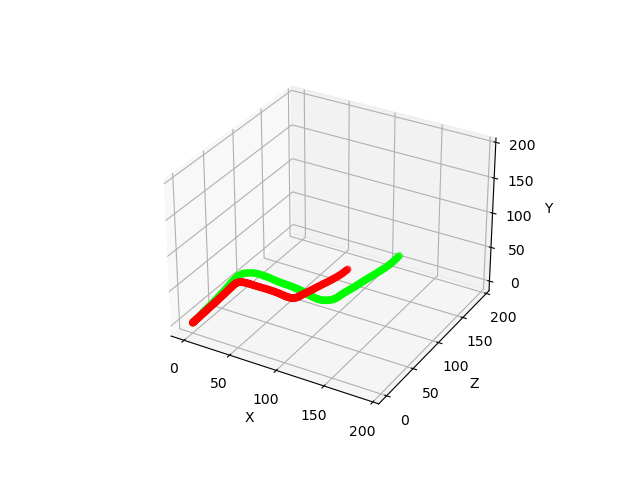

In [20]:
t_abs_all = np.array(t_abs_all)
if KITTI == True:
    t_abs_gt = np.array(t_abs_gt)
# plt.plot(t_abs_all[:,2], t_abs_all[:,0])
# plt.show()
%matplotlib widget
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax2 = fig.add_subplot(projection='3d')
# pt = (t_abs_all[0, 0], t_abs_all[0, 1], t_abs_all[0, 2])
ax.scatter(t_abs_all[:, 0], t_abs_all[:, 2], t_abs_all[:, 1], color=[(0, 1, 0)])
maximum = None
minimum = None

if KITTI == True:
    ax.scatter(t_abs_gt[:, 0], t_abs_gt[:, 2], t_abs_gt[:, 1], color=(1, 0, 0))
    minimum = np.array(np.concatenate([t_abs_all, t_abs_gt])).min()
    maximum = np.array(np.concatenate([t_abs_all, t_abs_gt])).max()
else:
    minimum = np.array(t_abs_all).min()
    maximum = np.array(t_abs_all).max()
    
ax.set_xlim([minimum, maximum])
ax.set_ylim([minimum, maximum])
ax.set_zlim([minimum, maximum])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
# plt.plot(t_abs_all[:, 0], t_abs_all[:, 1], t_abs_all[:, 2])
plt.show()

